In [1]:
!pip install -r requirements.txt -q


[notice] A new release of pip available: 22.2.2 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import gymnasium as gym
import torch
import numpy as np
import torch.nn as nn
import random
from collections import deque
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
import pickle
import wandb

In [3]:
environment = "ALE/Breakout-v5"
bs = 32
replay_memory_size= 400_000 #replay memory max size
sync_every_n_steps = 10_000
gamma = 0.99
lr=0.0000625
epsilon = 1
final_epsilon = 0.1,
loss_fn = nn.SmoothL1Loss()
Optimizer = torch.optim.Adam
replay_start_size = 50_000
FRAMES_TO_TRAIN = 10_000_000
EPOCH_SIZE = 50_000
BASE_MODEL = None
final_exploration_frame = 1_000_000
MIN_STACK_SIZE = 4
max_grad_norm = 10
adam_epsilon = 1.5e-4
replay_period = 1

In [4]:
config = {
    "learning_rate": lr,
    "architecture": "DQN-Deepmind-2015",
    "environment": environment,
    "epsilon": epsilon,
    "final_epsilon": final_epsilon,
    "gamma":gamma,
    "bs":bs,
    "replay_memory_size":replay_memory_size,
    "sync_every_n_steps": sync_every_n_steps,
    "loss": str(loss_fn),
    "Optimizer": Optimizer.__name__,
    "frames_to_train": FRAMES_TO_TRAIN,
    "epoch_size":EPOCH_SIZE,
    "base_model": BASE_MODEL,
    "final_exploration_frame":final_exploration_frame,
    "replay_start_size":replay_start_size,
    "max_grad_norm":max_grad_norm,
    "adam_epsilon":adam_epsilon,
    "replay_period":replay_period
    }

In [6]:
wandb.init(
    # set the wandb project where this run will be logged
    project="atari",
    
    # track hyperparameters and run metadata
    config=config
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: garethmd. Use `wandb login --relogin` to force relogin


In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [27]:
class TorchEnv:
    def __init__(self, env: gym.Env, transforms=None, terminate_after_lose_life=True, image_listener=None):
        self.env = env
        self.n_observations = self.env.observation_space.shape[0]
        self.n_actions = self.env.action_space.n
        self.transforms = transforms
        self.terminate_after_lose_life = terminate_after_lose_life
        self.image_listener = image_listener
        

    def step(self, a):
        s, r, terminated, _, info = self.env.step(a)
        r = np.clip(r, -1, 1) # clip rewards between -1 and 1 as per DeepMind

        if self.image_listener:
            self.image_listener(s)

        # terminate if we lose a life as per Rainbow
        # https://arxiv.org/pdf/1710.02298.pdf
        if self.lives != info['lives'] and self.terminate_after_lose_life:
            terminated = True
        
        s = s[None, :, :, :] # HWC -> BCHW
        
        if self.transforms:
            s = self.transforms(s)
        return s, r, terminated

    def reset(self, *args, **kwargs):
        s, info = self.env.reset(*args, **kwargs)
        if self.image_listener:
            self.image_listener(s)
        self.lives = info['lives']
    
        # at episode start, repeat and stack the first state 4 times
        stack = [s]
        stack = np.vstack([s[None, :, :, :]] * MIN_STACK_SIZE) # HWC -> BHWC
        
        if self.transforms:
            stack = self.transforms(stack)
        
        return stack

    def close(self):
        return self.env.close()
    
    def sample(self):
        return np.random.randint(self.n_actions)

env = TorchEnv(gym.make(environment))

## Breakout

### Preprocessing

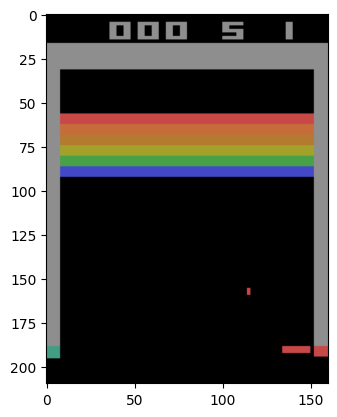

In [42]:
env = TorchEnv(gym.make(environment))
stack = env.reset() 
for _ in range(10):
    stack, *_ = env.step(env.sample())
plt.imshow(stack[-1])
plt.savefig('breakout-raw.png')

#### Greyscale

In [43]:
class BatchGrayscale:
    def __init__(self):
        self.transforms = transforms.Grayscale()

    def __call__(self, batch: torch.Tensor):
        """
        Args:
            batch (torch.Tensor): expects batch to be of shape (B, H, W, C)
        Returns:
            torch.Tensor: batch of shape (B, C, H, W)
        """
        grey_pt_stack = torch.stack([self.transforms(s.permute(2,0,1)) for s in batch])
        return grey_pt_stack

In [96]:
def imglistshow(v_slice, filename):
    plt.figure()
    #subplot(r,c) provide the no. of rows and columns
    f, axarr = plt.subplots(nrows=1, ncols=4)
    
    # use the created array to output your multiple images. In this case I have stacked 4 images vertically
    for i, image in enumerate(v_slice):
        axarr[i].axis("off")
        axarr[i].imshow(image)
    
    plt.savefig(filename)

In [57]:
stack.shape

(1, 210, 160, 3)

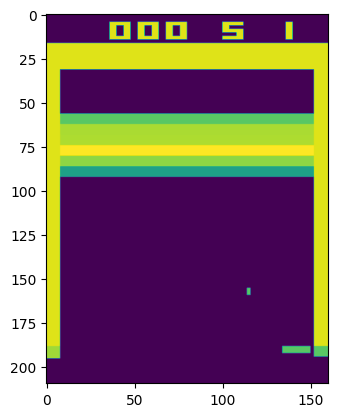

In [67]:
greyscale = BatchGrayscale() #transforms to grayscale
pt_stack = torch.from_numpy(stack).to(device)
img_stack = greyscale(pt_stack)
plt.imshow(img_stack.squeeze(1).permute(1, 2, 0))

In [68]:
class BatchDownsample:
    def __init__(self, size=(110,84)):
        self.size = size
    
    def __call__(self, batch: torch.Tensor):
        """
        Args:
            batch (torch.Tensor): expects batch to be of shape (B, C, H, W)
        Returns:
            torch.Tensor: batch of shape (B, C, H, W)
        """
        orig_dtype = batch.dtype
        result = nn.functional.interpolate(batch.float(), size=self.size,  mode='bilinear')
        return result.type(orig_dtype)

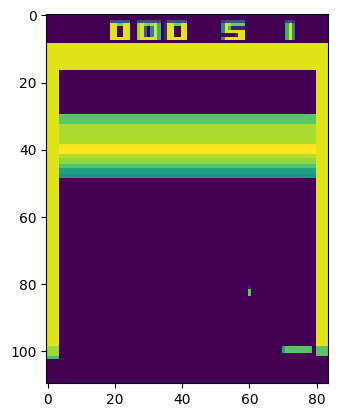

In [70]:
batch_downsample = BatchDownsample(size=(110,84))
downsampled_stack = batch_downsample(img_stack)
plt.imshow(downsampled_stack.squeeze(1).permute(1, 2, 0))

In [71]:
class BatchCrop:
    def __init__(self, size=(84,84)):
        self.size = size
    
    def __call__(self, batch: torch.Tensor):
        """ crop 17 pixels from top and bottom
        Args:
            batch (torch.Tensor): expects batch to be of shape (B, C, H, W)
        Returns:
            torch.Tensor: batch of shape (B, C, H, W)
        """
        return batch[:, :,  17:17+self.size[0], :] # crop 17 pixels from top and bottom

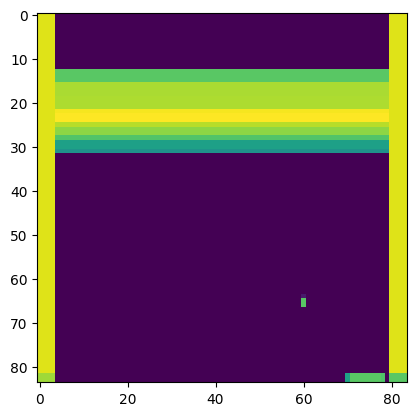

In [72]:
batch_downsample = BatchCrop(size=(84,84))
batch_downsample = batch_downsample(downsampled_stack)
plt.imshow(batch_downsample.squeeze(1).permute(1, 2, 0))

In [73]:
class BatchToTensor:
    def __init__(self, device):
        self.device = device

    def __call__(self, batch: np.array):
        """
        Args:
            batch (np.array): expects a numpy array
        Returns:
            torch.Tensor: torch tensor on device
        """
        return torch.from_numpy(batch).to(self.device)

In [74]:
class TransformPipeline:
    def __init__(self, transforms):
        self.transforms = transforms
    
    def __call__(self, batch: torch.Tensor):
        for transform in self.transforms:
            batch = transform(batch)
        return batch

In [75]:
pipeline = TransformPipeline([BatchToTensor(device), BatchGrayscale(), BatchDownsample(), BatchCrop()])

In [76]:
def test_should_preprocess_to_correct_shape():   
    pipeline = TransformPipeline([BatchToTensor(device), BatchGrayscale(), BatchDownsample(), BatchCrop()]) 
    env = TorchEnv(gym.make(environment))
    s = env.reset()
    preprocessed_s_prime = pipeline(s)
    assert preprocessed_s_prime.shape == (4,1,84,84) # 4 frames, 1 channel, 84x84

test_should_preprocess_to_correct_shape()

## fill replay memory
here we fill the replay memory with downsampled cropped stacks

In [77]:
class ExperienceReplay:
    def __init__(self, maxlen: int) -> None:
        self.deque = deque(maxlen=maxlen)
        self.maxlen = maxlen

    def append(self, x: tuple)-> None:
        self.deque.append(x)

    def sample(self, bs: int) -> list:
        return random.sample(self.deque, min(len(self), bs))

    def __len__(self) -> int:
        return len(self.deque)
    
    @classmethod
    def load(cls, path: str):
        with open(path, 'rb') as f:
            return pickle.load(f)
        
    def save(self, path: str):
        with open(path, 'wb') as f:
            return pickle.dump(self, f)

def fill(replay_memory:ExperienceReplay, env:TorchEnv, fill_size:int = replay_start_size) -> None :
    while len(replay_memory)<fill_size:
        s = env.reset()
        terminated=False
        while terminated == False and len(replay_memory)<fill_size:
            a = env.sample()
            s_prime, r, terminated = env.step(a)
            s_prime = torch.cat([s, s_prime])[-4:]
            replay_memory.append((s, a, r, s_prime, terminated))
            s = s_prime

In [82]:
env = TorchEnv(gym.make(environment), transforms=pipeline)
replay_memory = ExperienceReplay(replay_memory_size)
fill(replay_memory, env, fill_size=100)
samples = replay_memory.sample(3)
s, a, r, s_prime, terminated = samples[0]
s.shape

torch.Size([4, 1, 84, 84])

<Figure size 640x480 with 0 Axes>

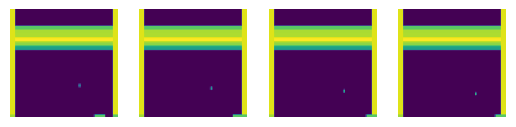

In [97]:
imglistshow(s.squeeze(1).cpu(), 'breakout-processed.png')

In [22]:
wandb.Image(s[:2].cpu(), caption="Top: Frame at t , Bottom: Frame at t+1")

## Define the Atari DQN

In [99]:
class DQNDeepmind2013(nn.Module):
    def __init__(self, n_actions):
        super(DQNDeepmind2013, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(4, 16, 8, stride=4),
            nn.ReLU(),
            nn.Conv2d(16, 32, 4, stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32*9*9, 256),
            nn.ReLU(),
            nn.Linear(256, n_actions)
        )
        
    def forward(self, s):
        return self.conv(s) 
    


In [100]:
class AtariDQN(nn.Module):
    def __init__(self, net, n_actions, normalize=True):
        super(AtariDQN, self).__init__()
        self.net = net
        self.n_actions = n_actions
        self.normalize = normalize

    def forward(self, s: torch.Tensor):
        '''
        Args:
            s (torch.Tensor): batch of shape (B, H, W)
        Returns:
            torch.Tensor: batch of shape (B, n_actions)
        '''
        if self.normalize:
            s = s.float() / 255.0
        return self.net(s)

    def select_next_action(self, s, epsilon):
        with torch.no_grad():
            use_greedy = np.random.binomial(1, 1-epsilon)
            if use_greedy:
                a = self(s).argmax().item()
            else:
                a = np.random.randint(self.n_actions)
            return a

# Train Network

In [26]:
dqn = AtariDQN(DQNDeepmind2013(env.n_actions).to(device), n_actions=env.n_actions).to(device)
if BASE_MODEL is not None:
    print(f"Loading base model from {BASE_MODEL}")
    dqn.load_state_dict(torch.load(BASE_MODEL))

In [27]:
def test_should_return_value_for_each_action():
    n_actions = 4
    dqn = AtariDQN(DQNDeepmind2013(n_actions), n_actions=n_actions)
    samples = torch.randn(32, 4, 1, 84, 84)
    out = dqn(samples[0].squeeze(1).unsqueeze(0)).squeeze(0)
    assert out.shape[0] == env.n_actions

test_should_return_value_for_each_action()

In [28]:
optimizer = Optimizer(dqn.parameters(),  lr=lr, eps=adam_epsilon)
dqn.train()

AtariDQN(
  (net): DQNDeepmind2013(
    (conv): Sequential(
      (0): Conv2d(4, 16, kernel_size=(8, 8), stride=(4, 4))
      (1): ReLU()
      (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2))
      (3): ReLU()
      (4): Flatten(start_dim=1, end_dim=-1)
      (5): Linear(in_features=2592, out_features=256, bias=True)
      (6): ReLU()
      (7): Linear(in_features=256, out_features=4, bias=True)
    )
  )
)

In [29]:
def atari_collate(batch):
    s_j, a_j, r_j, s_prime_j, terminated_j = list(zip(*batch))
    return (torch.stack(s_j).squeeze(2).to(device), 
            torch.tensor(a_j).to(device), 
            torch.tensor(r_j).to(device), 
            torch.stack(s_prime_j).squeeze(2).to(device), 
            (~torch.tensor(terminated_j)).to(device).half()
    )
def get_batch_efficient(self, batch, collate_fn=None):
    s, a, r, s_prime, not_terminated = collate_fn(batch)

    y_hat = self(s).gather(1, a.unsqueeze(1)).squeeze() # gather the values at the indices given by the actions a

    with torch.no_grad():
        next_values, _ = self(s_prime).max(dim=1)
        next_values = next_values.clone().detach()
    y_j = r.detach().clone() + gamma * next_values * not_terminated # if terminated then not_terminated is set to zero (y_j = r)
    return y_hat, y_j

def get_epsilon(epsilon, final_epsilon=0.1, steps_to_anneal=final_exploration_frame):
    if epsilon > final_epsilon:
        epsilon -= (1/steps_to_anneal) * (1-final_epsilon)
    return epsilon

In [30]:
def validate(dqn, env):
    k = 0
    total_rewards = []
    while k < 15*60*5: #15 frames / sec * 60 seconds * 5 minutes
        terminated = False
        rewards = 0
        s = env.reset()
        while terminated == False:
            a = dqn.select_next_action(s.squeeze(1).unsqueeze(0), 0.1)
            s_prime, r, terminated = env.step(a)
            s_prime = torch.cat([s, s_prime])[-4:]
            s = s_prime
            rewards += r
            k += 1
        total_rewards.append(rewards)
    return sum(total_rewards)/len(total_rewards)

validate(dqn, env)

0.52

In [31]:
n_epochs = FRAMES_TO_TRAIN // EPOCH_SIZE
print(n_epochs)
track = True
for epoch in range(n_epochs):
    epoch_loss, epoch_reward, k, epoch_episodes = 0, 0, 0, 0
    while k < EPOCH_SIZE:
        terminated = False
        s = env.reset()
        while terminated == False:
            a = dqn.select_next_action(s.squeeze(1).unsqueeze(0), epsilon)
            s_prime, r, terminated = env.step(a)
            s_prime = torch.cat([s, s_prime])[-4:]
            replay_memory.append((s, a, r, s_prime, terminated))
            epsilon = get_epsilon(epsilon)
            s = s_prime

            if len(replay_memory) > replay_start_size:
                optimizer.zero_grad()
                batch = replay_memory.sample(bs)
                y_hat, y = get_batch_efficient(dqn, batch,  collate_fn=atari_collate)
                loss = loss_fn(y_hat, y)
                loss.backward()
                torch.nn.utils.clip_grad_value_(dqn.parameters(), max_grad_norm)
                optimizer.step()
                        
                
                loss = loss.detach()
                epoch_loss += loss.item()
            epoch_reward += r
            k += 1
        epoch_episodes += 1
    
    if track:
        validate_reward = validate(dqn, env)
        torch.save(dqn.state_dict(), 'breakout2013.pt')
        wandb.log_model(name=f"breakout2013-{wandb.run.id}", path='breakout2013.pt')
        wandb.log({"epoch":epoch,
                "step_loss": epoch_loss / k, 
                "reward": epoch_reward / epoch_episodes,
                "step":k,
                "epsilon": epsilon,
                "validate_reward":validate_reward
                })
        print(f'epochs {epoch}, step_loss {epoch_loss / k}, reward {epoch_reward / epoch_episodes}, k {k}, epsilon {epsilon}')
env.close()

200


KeyboardInterrupt: 

In [302]:
wandb.finish()

epoch,▁▃▆█
epsilon,█▆▃▁
reward,▁█▃█
step,█▄▁█
step_loss,█▂▁▁
epoch,3
epsilon,0.99636
reward,1.5283
step,10160
step_loss,0.00035


### Validation

In [102]:
MODEL_FILE_PATH = 'breakout-2013.pt'
env = TorchEnv(gym.make(environment), transforms=pipeline, terminate_after_lose_life=False)
dqn = AtariDQN(DQNDeepmind2013(env.n_actions).to(device), n_actions=env.n_actions).to(device)
dqn.load_state_dict(torch.load(MODEL_FILE_PATH, map_location=torch.device('cpu')))


<All keys matched successfully>

In [103]:

def validate(dqn, env):
    k = 0
    total_rewards = []
    while k < 15*60*5: #15 frames / sec * 60 seconds * 5 minutes
        terminated = False
        rewards = 0
        s = env.reset()
        while terminated == False:
            a = dqn.select_next_action(s.squeeze(1).unsqueeze(0), 0.05)
            s_prime, r, terminated = env.step(a)
            s_prime = torch.cat([s, s_prime])[-4:]
            s = s_prime
            rewards += r
            k += 1
        total_rewards.append(rewards)
    return sum(total_rewards)/len(total_rewards)

validate(dqn, env)

13.666666666666666

In [ ]:
from video import WRITERS

In [160]:
WRITERS["opencv"](iter(env.images), f"{MODEL_FILE_PATH}.mp4")

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
